In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import _tree
from sklearn.tree import DecisionTreeClassifier
from clingo.control import Control
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

np.random.seed(42)

In [3]:
def tree_to_cnf(tree, feature_names, v1 = 1, v2 = 0):
    tree = tree.tree_
    fact_clauses = []
    foil_clauses = []
    var_mapping = {}
    var_counter = [1]  # Mutable counter

    def fresh_var():
        name = f'p{var_counter[0]}'
        var_counter[0] += 1
        return name

    def traverse(node, path):
        if tree.feature[node] == _tree.TREE_UNDEFINED:
            c = tree.value[node][0].argmax()
            if c != v1:
                fact_clauses.append(path)
            if c != v2:
                foil_clauses.append(path)
        else:
            feature_index = tree.feature[node]
            threshold = round(tree.threshold[node], 4)
            feature = feature_names[feature_index]

            # Search for an existing variable with the same [feature, threshold]
            existing_var = None
            for var, pair in var_mapping.items():
                if pair == [feature, threshold]:
                    existing_var = var
                    break

            if existing_var is not None:
                var = existing_var  # Reuse the existing variable
            else:
                var = fresh_var()
                var_mapping[var] = [feature, threshold]

            # Left: feature <= threshold  → -var
            traverse(
                tree.children_left[node],
                path + [f'-{var}']
            )

            # Right: feature > threshold → var
            traverse(
                tree.children_right[node],
                path + [var]
            )

    # Start traversal from root
    traverse(0, [])

    # Construct CNF formulas
    fact_cnf = ' & '.join([' | '.join(clause) for clause in fact_clauses])
    foil_cnf = ' & '.join([' | '.join(clause) for clause in foil_clauses])

    return {
        'fact_cnf': fact_cnf,
        'foil_cnf': foil_cnf,
        'var_mapping': var_mapping
    }

ENC = {
    "GLOBAL_CE" : "prototype/enc_def3.lp",
    "CF_CE"     : "prototype/enc_def5.lp",
    "CF_DIFF"   : "prototype/enc_def6.lp"
}

def __parse_cnf(str):
    cnf = []
    for str_cl in str.split("&"):
        cl = []
        for str_lit in str_cl.split("|"):
            s = str_lit.strip()
            if s.startswith('-'):
                cl.append((s[1:],False))
            else:
                cl.append((s,True))
        cnf.append(cl)
    
    return cnf

def __cnf_to_facts(instance_cnf,fact_cnf,foil_cnf):
    facts = []
    i = 1
    for cl in instance_cnf:
        facts.append(f"instance_cl({i}).")
        for l,t in cl:
            sign = "t" if t else "f"
            facts.append(f"lit({i},{l},{sign}).")
        i += 1
    for cl in fact_cnf:
        facts.append(f"fact_cl({i}).")
        for l,t in cl:
            sign = "t" if t else "f"
            facts.append(f"lit({i},{l},{sign}).")
        i += 1
    for cl in foil_cnf:
        facts.append(f"foil_cl({i}).")
        for l,t in cl:
            sign = "t" if t else "f"
            facts.append(f"lit({i},{l},{sign}).")
        i += 1
        
    return facts


def __cnf_to_str(cnf):
    cl_str = []
    for cl in cnf:
        parse_lit = lambda l,s: l if s else f"-{l}" 
        cl_str.append(" | ".join([ parse_lit(l,s) for l,s in cl ]))
    
    return "  &  ".join(cl_str)


def __parse_answer_set(answer_set):
    theta = {}
    theta_p = {}
    chi = {}
    for sym in answer_set.symbols(shown=True):
        if sym.match('theta_lit',3):
            c = sym.arguments[0].number
            l = str(sym.arguments[1])
            s = str(sym.arguments[2])

            if c not in theta:
                theta[c] = []
            theta[c].append((l,s == "t"))
        elif sym.match('theta_p_lit',3):
            c = sym.arguments[0].number
            l = str(sym.arguments[1])
            s = str(sym.arguments[2])

            if c not in theta_p:
                theta_p[c] = []
            theta_p[c].append((l,s == "t"))
        elif sym.match('chi_lit',3):
            c = sym.arguments[0].number
            l = str(sym.arguments[1])
            s = str(sym.arguments[2])

            if c not in chi:
                chi[c] = []
            chi[c].append((l,s == "t"))

    
    return (list(dict(sorted(theta.items())).values()), 
            list(dict(sorted(theta_p.items())).values()), 
            list(dict(sorted(chi.items())).values()))


def __clingo_solve(encoding, n_models=1, max_clauses=5, max_lits=1):
    ctl = Control(['-Wnone', '--opt-mode=optN', '-t8', f'-c n_clauses={max_clauses}' , f'-c n_lits={max_lits}', '--verbose'])
    ctl.add(encoding)
    ctl.ground([("base", [])])
    answer_set = None
    cost = None
    opt_models = 0
    def on_model(model):
        nonlocal answer_set, cost, opt_models
        prev_cost = cost
        cost = model.cost
        if prev_cost == cost:
            opt_models += 1
            theta, theta_p, chi  = __parse_answer_set(model)
            answer_set = theta, theta_p, chi
            print(f"SOLUTION (cost {cost}):")
            print("Theta:")
            print(__cnf_to_str(theta))
            print("Theta':")
            print(__cnf_to_str(theta_p))
            print("Chi:")
            print(__cnf_to_str(chi))
            print()

        if n_models > 0 and opt_models >= n_models:
            ctl.interrupt()
        
    ctl.solve(on_model=on_model)

    return answer_set

def evaluate_instance_against_vars(instance_as_dict, var_mapping):
    result = {}
    for var, (feature, threshold) in var_mapping.items():
        result[var] = instance_as_dict[feature] <= threshold
    return result

In [ ]:
# Load Breast Cancer dataset
breast_cancer = load_breast_cancer()
df = pd.DataFrame(data=breast_cancer.data, columns=breast_cancer.feature_names)

# Remove spaces in feature names
df.columns = df.columns.str.replace(' ', '')

# 1. Dataset

df['target'] = breast_cancer.target
X = df.drop(columns = ['target'], axis = 1)
y = df['target']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model.

model = DecisionTreeClassifier(max_depth = 3, random_state = 42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print()

output = tree_to_cnf(model, X.columns)
cnf1 = output['fact_cnf']
cnf2 = output['foil_cnf']
var_map = output['var_mapping']

for key, (feature, threshold) in var_map.items():
    print(f'{key}: {feature} <= {threshold}')
print()

fact = __parse_cnf(cnf1)
foil = __parse_cnf(cnf2)
print(f'Fact: {cnf1}')
print(f'Foil: {cnf2}')
print()

print(f'Global contrastive explanation:')
encoding = ''.join(__cnf_to_facts([],fact,foil))
with open(ENC['GLOBAL_CE'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 3, max_lits = 3)
print()

# Compute explanations for positive predictions.
index = np.random.choice(np.where(y_pred == 1)[0])
instance = str()
instance_as_dict = evaluate_instance_against_vars(X_test.iloc[index].to_dict(), var_map)
for j in range(len(instance_as_dict.keys())):
    key = list(instance_as_dict.keys())[j]
    if j > 0:
        instance += ' & '
    if instance_as_dict[key] == 0:
        instance += f'-{key}'
    else:
        instance += f'{key}'
print(f'Instance: {instance}')
_instance = __parse_cnf(instance)
print(f'Prediction: {y_pred[index]}')
print()

print(f'Counterfactual contrastive explanation:')
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_CE'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 7)
print()

print(f'Counterfactual difference:')
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_DIFF'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 7)
print()

Accuracy: 0.9473684210526315

p1: meanconcavepoints <= 0.0513
p2: worstradius <= 16.83
p3: areaerror <= 48.7
p4: meantexture <= 16.19
p5: worstconcavepoints <= 0.1465
p6: worstperimeter <= 115.25
p7: fractaldimensionerror <= 0.0129
Fact: -p1 | -p2 | p3 & -p1 | p2 | p4 & p1 | -p5 | p6 & p1 | p5 | -p7
Foil: -p1 | -p2 | -p3 & -p1 | p2 | -p4 & p1 | -p5 | -p6 & p1 | p5 | p7

Instance: p1 & p2 & p3 & -p4 & p5 & p6 & p7
Prediction: 1

Counterfactual contrastive explanation:
SOLUTION (cost [4, -2]):
Theta:
p3
Theta':
-p3
Chi:
p2  &  p1


Counterfactual difference:


In [ ]:
# Load german credit
dataset = openml.datasets.get_dataset(31)
X, y, _, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
y_mapped = y.map({'good': 0, 'bad': 1})

# 3. Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=["category", "object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["number", "float", "int"]).columns.tolist()

# 4. Create the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # keep numerical columns
)

# 5. Apply transform to X directly
X_transformed = preprocessor.fit_transform(X)

# 6. Optional: get feature names
ohe = preprocessor.named_transformers_['cat']
encoded_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = list(encoded_feature_names) + numerical_cols

# 7. Convert to DataFrame (optional)
X_transformed_df = pd.DataFrame(X_transformed, columns=all_feature_names)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y_mapped, test_size=0.2, random_state=42)

# Train a model.

model = DecisionTreeClassifier(max_depth = 3, random_state = 42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print()

output = tree_to_cnf(model, X_transformed_df.columns)
cnf1 = output['fact_cnf']
cnf2 = output['foil_cnf']
var_map = output['var_mapping']

for key, (feature, threshold) in var_map.items():
    print(f'{key}: {feature} <= {threshold}')
print()

fact = __parse_cnf(cnf1)
foil = __parse_cnf(cnf2)
print(f'Fact: {cnf1}')
print(f'Foil: {cnf2}')
print()

# Compute explanations for positive predictions.
index = np.random.choice(np.where(y_pred == 1)[0])
instance = str()
instance_as_dict = evaluate_instance_against_vars(X_test.iloc[index].to_dict(), var_map)
for j in range(len(instance_as_dict.keys())):
    key = list(instance_as_dict.keys())[j]
    if j > 0:
        instance += ' & '
    if instance_as_dict[key] == 0:
        instance += f'-{key}'
    else:
        instance += f'{key}'
print(f'Instance: {instance}')
_instance = __parse_cnf(instance)
print(f'Prediction: {y_pred[index]}')
print()

print(f'Counterfactual contrastive explanation:')
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_CE'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 7)
print()

print(f'Counterfactual difference:')
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_DIFF'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 7)
print()

Accuracy: 0.775
p1: checking_status_no checking <= 0.5
p2: duration <= 22.5
p3: credit_history_all paid <= 0.5
p4: savings_status_<100 <= 0.5
p5: other_payment_plans_none <= 0.5
p6: purpose_radio/tv <= 0.5
p7: age <= 31.5
Fact: -p1 | -p2 | -p3 & -p1 | p2 | -p4 & p1 | -p5 | -p6 & p1 | -p5 | p6 & p1 | p5 | -p7 & p1 | p5 | p7
Foil: -p1 | -p2 | p3 & -p1 | p2 | p4

Instance: p1 & -p2 & p3 & -p4 & p5 & p6 & -p7
Prediction: 1
SOLUTION (cost [4, -2]):
Theta:
p1
Theta':
-p1
Chi:
-p4  &  -p2




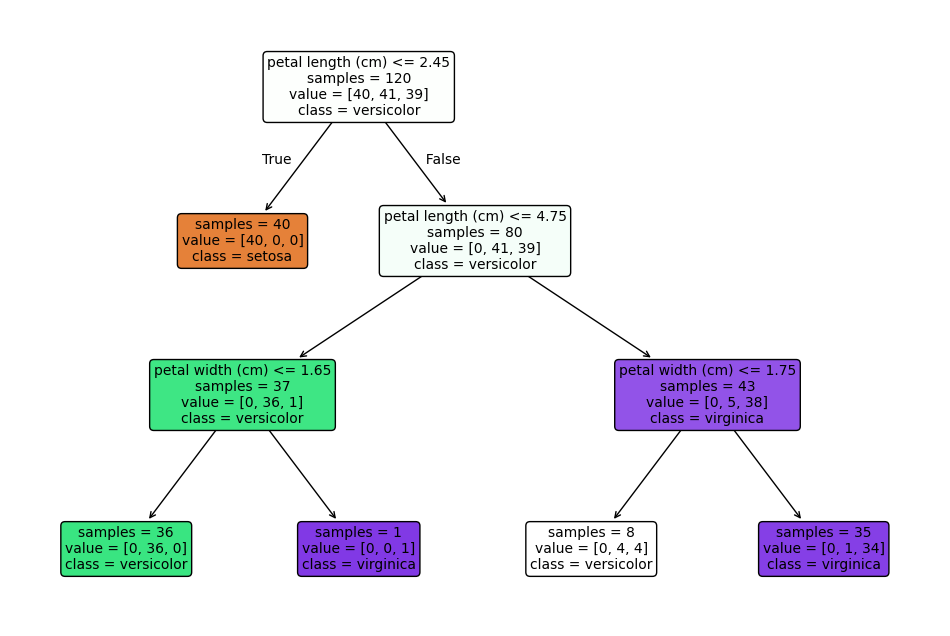

Accuracy: 1.0

p1: petallength(cm) <= 2.45
p2: petallength(cm) <= 4.75
p3: petalwidth(cm) <= 1.65
p4: petalwidth(cm) <= 1.75

Fact: -p1 & p1 | -p2 | p3 & p1 | p2 | p4
Foil: -p1 & p1 | -p2 | -p3 & p1 | p2 | -p4

Global contrast:
SOLUTION (cost [9, -1]):
Theta:
p3 | -p2  &  p2 | p4
Theta':
-p2 | -p3  &  p2 | -p4
Chi:
-p1


Instance: -p1 & p2 & p3 & p4
Prediction: 1

Counterfactual contrastive explanation:
SOLUTION (cost [4, -2]):
Theta:
p3
Theta':
-p3
Chi:
p2  &  -p1


Counterfactual difference:
SOLUTION (cost [5, -3]):
Theta:
p3
Theta':
-p3
Chi:
p2  &  p4  &  -p1




In [ ]:
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df.columns = df.columns.str.replace(' ', '')

df['target'] = iris.target
X = df.drop(columns = ['target'], axis = 1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(max_depth = 3, random_state = 42)
model.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=iris.feature_names, class_names=iris.target_names, filled=True, rounded=True, fontsize=10, impurity=False, proportion=False)
plt.show()

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print()

output = tree_to_cnf(model, X_train.columns, 1, 2)
cnf1 = output['fact_cnf']
cnf2 = output['foil_cnf']
var_map = output['var_mapping']

for key, (feature, threshold) in var_map.items():
    print(f'{key}: {feature} <= {threshold}')
print()

fact = __parse_cnf(cnf1)
foil = __parse_cnf(cnf2)
print(f'Fact: {cnf1}')
print(f'Foil: {cnf2}')
print()

print(f'Global contrast:')
encoding = ''.join(__cnf_to_facts([],fact,foil))
with open(ENC['GLOBAL_CE'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 3, max_lits = 3)
print()

# Compute explanations for positive predictions.
index = np.random.choice(np.where(y_pred == 1)[0])
instance = str()
instance_as_dict = evaluate_instance_against_vars(X_test.iloc[index].to_dict(), var_map)
for j in range(len(instance_as_dict.keys())):
    key = list(instance_as_dict.keys())[j]
    if j > 0:
        instance += ' & '
    if instance_as_dict[key] == 0:
        instance += f'-{key}'
    else:
        instance += f'{key}'
print(f'Instance: {instance}')
_instance = __parse_cnf(instance)
print(f'Prediction: {y_pred[index]}')
print()

print(f'Counterfactual contrastive explanation:')
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_CE'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 4)
print()

print(f'Counterfactual difference:')
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_DIFF'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 4)
print()

In [ ]:
# Car classifier
dataset = openml.datasets.get_dataset(40975)
X, y, _, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
y_mapped = y.map({'unacc': 0, 'acc': 1, 'good' : 2, 'vgood' : 3})

# One hot encode categorical columns.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), X.columns)
    ],
    remainder='passthrough'  # keep numerical columns
)

X_transformed = preprocessor.fit_transform(X)

# Get new feature names
ohe = preprocessor.named_transformers_['cat']
encoded_feature_names = ohe.get_feature_names_out(X.columns)
all_feature_names = list(encoded_feature_names)

X_transformed_df = pd.DataFrame(X_transformed, columns=all_feature_names)

X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y_mapped, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(max_depth = 8, random_state = 42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print()

output = tree_to_cnf(model, X_transformed_df.columns, 2, 3)
cnf1 = output['fact_cnf']
cnf2 = output['foil_cnf']
var_map = output['var_mapping']

for key, (feature, threshold) in var_map.items():
    print(f'{key}: {feature} <= {threshold}')
print()

fact = __parse_cnf(cnf1)
foil = __parse_cnf(cnf2)
print(f'Fact: {cnf1}')
print(f'Foil: {cnf2}')
print()

print(f'Global contrast:')
encoding = ''.join(__cnf_to_facts([],fact,foil))
with open(ENC['GLOBAL_CE'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 16, max_lits = 16)
print()

# Compute explanations for positive predictions.
index = np.random.choice(np.where(y_pred == 2)[0])
instance = str()
instance_as_dict = evaluate_instance_against_vars(X_test.iloc[index].to_dict(), var_map)
for j in range(len(instance_as_dict.keys())):
    key = list(instance_as_dict.keys())[j]
    if j > 0:
        instance += ' & '
    if instance_as_dict[key] == 0:
        instance += f'-{key}'
    else:
        instance += f'{key}'
print(f'Instance: {instance}')
_instance = __parse_cnf(instance)
print(f'Prediction: {y_pred[index]}')
print()

print(f'Counterfactual contrastive explanation:')
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_CE'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 16)
print()

print(f'Counterfactual difference:')
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_DIFF'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 16)
print()

Accuracy: 0.9566473988439307

p1: safety_low <= 0.5
p2: persons_2 <= 0.5
p3: maint_vhigh <= 0.5
p4: buying_low <= 0.5
p5: lug_boot_small <= 0.5
p6: buying_med <= 0.5
p7: maint_high <= 0.5
p8: safety_high <= 0.5
p9: buying_high <= 0.5
p10: maint_low <= 0.5
p11: doors_2 <= 0.5
p12: persons_more <= 0.5
p13: safety_med <= 0.5
p14: lug_boot_med <= 0.5
p15: persons_4 <= 0.5
p16: lug_boot_big <= 0.5

Fact: -p1 | -p2 | -p3 | -p4 | -p5 | -p6 | -p7 | -p8 & -p1 | -p2 | -p3 | -p4 | -p5 | -p6 | -p7 | p8 & -p1 | -p2 | -p3 | -p4 | -p5 | -p6 | p7 | -p9 & -p1 | -p2 | -p3 | -p4 | -p5 | -p6 | p7 | p9 & -p1 | -p2 | -p3 | -p4 | -p5 | p6 | -p10 | -p8 & -p1 | -p2 | -p3 | -p4 | -p5 | p6 | -p10 | p8 & -p1 | -p2 | -p3 | -p4 | -p5 | p6 | p10 | p8 & -p1 | -p2 | -p3 | -p4 | p5 | -p8 | -p6 & -p1 | -p2 | -p3 | -p4 | p5 | -p8 | p6 | -p7 & -p1 | -p2 | -p3 | -p4 | p5 | -p8 | p6 | p7 & -p1 | -p2 | -p3 | -p4 | p5 | p8 | -p11 | -p9 & -p1 | -p2 | -p3 | -p4 | p5 | p8 | -p11 | p9 & -p1 | -p2 | -p3 | -p4 | p5 | p8 | p11 | -p1